In [89]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy import stats
# import missingno as msno
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import warnings
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [90]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing as skp 
# from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
import xgboost as xg
from sklearn.linear_model import LogisticRegression



# Kaggle's Bike Sharing Demand 

## Overview

## Introduction

### Original Features
- datetime - hourly date + timestamp  
- season - 
    - 1 = spring
    - 2 = summer
    - 3 = fall 
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

## Basic Analysis
* histogram the data
* create feature correlation heatmap
* add time features (year,year-month,month,week_number,day_of_week,day,hour)
* use log transformer 
* test increase demand year-over-year, month-over-month,

## Feature Ingeneering
* use desicision tree to convert hours into bins
* use desicision tree to convert temps into bins
* create dummy variables
* seperate data to casual and registered



### Sources
our challange:
* https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/
* https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
* https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile

How to use XGBoost:
* For Dummies - https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
* http://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/XG_Boost_NB.ipynb
* https://github.com/dmlc/xgboost/blob/master/doc/parameter.md


Trasnformers for inbalanced data:
http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html


# Get the data



In [153]:
ods_bike_raw = pd.read_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
# ods_bike_raw = pd.read_csv('C:\\Users\\roy.leiser\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
ods_bike = ods_bike_raw.copy()
ods_bike.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [154]:
target_columns = ['casual', 'registered', 'count']

# Feature Engineering 



In [155]:
def round_fractions(data):
    data['atemp_round'] = data['atemp'].apply(round)
    data['temp_round'] = data['temp'].apply(round)
    data['windspeed_round'] = data['windspeed'].apply(round)

In [156]:
def get_fractions(df):
    return df[['temp','atemp','windspeed']]

In [157]:
def add_time_measures(df):
#     Convert df.datetime to datetime:
    try:
        df['datetime']=df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    except TypeError:
        pass
#     add various time measures:
    df['year'] = df['datetime'].apply(lambda x: x.date().year)
    df['month'] = df['datetime'].apply(lambda x: x.date().month)
    df['weekday'] = df['datetime'].apply(lambda x: x.date().weekday())
    df['day'] = df['datetime'].apply(lambda x: x.date().day)
    df['hour'] = df['datetime'].apply(lambda x: x.time().hour)   

In [171]:
def drop_dateime(df):
    del df['datetime']

In [159]:
drop_dateime = FunctionTransformer(func=drop_dateime, validate=False)
add_time_measures_transformer = FunctionTransformer(func=add_time_measures, validate=False)
get_fractions_transformer = FunctionTransformer(func=get_fractions, validate=False)
round_transformer = FunctionTransformer(func=round, validate=False)

fraction_pipeline = Pipeline([('get_fractions_transformer',get_fractions_transformer),('round_transformer',round_transformer)])

In [160]:
def add_is_weekend(df):
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [0,1] else 0)    
# True if x % 2 == 0 else False
    
add_is_weekend_transformer = FunctionTransformer(func=add_is_weekend, validate=False)

In [162]:
def remove_windspeed_outliers(df):
        df['windspeed'] = df['windspeed'].apply(lambda x: x if x < 40 else 40)
        df['windspeed_round'] = df['windspeed_round'].apply(lambda x: x if x < 40 else 40)
        
remove_windspeed_outliers_transformer = FunctionTransformer(func=remove_windspeed_outliers, validate=False)

In [ ]:
def convert_to_single_target_column(df):
    df_casual = df.copy()
    del df_casual[['registered','count']]
    df_casual[is_casual] = 1
    df_casual['target'] = df_casual['casual']
    
    df_registered = df.copy()
    del df_registered[['casual','count']]
    df_registered[is_casual] = 0
    df_registered['target'] = df_registered['registered']
    
    pd.concat(['df_casual','df_registered'],ignore_index=True)

In [163]:
# def get_target_cols(df):
#     return df[['casual', 'registered', 'count']]

# targets_selector = FunctionTransformer(func=get_target_cols, validate=False)

In [166]:
log1p_transformer = FunctionTransformer(np.log1p)                                   
quant_transformer = QuantileTransformer(output_distribution='normal')
robust_transformer = RobustScaler()
norm_transformer = Normalizer()




## Converting Hour to bins in dummy variables?

# Model Preperations
### RMSLE Scorer

In [167]:
def rmsle(y_test, y_pred): 
    return np.sqrt(np.square(np.log(y_test + 1) - np.log(y_pred + 1)).mean())

# Model Preperations
### Define Classifiers

In [178]:
# Define classifiers
clf_LR = LogisticRegression()
clf_DT = DecisionTreeClassifier(max_depth=300,
                                min_samples_split=10,
                                min_samples_leaf=10)
clf_XGR = xg.XGBRegressor()
clf_XGC = xg.XGBClassifier()

# The Model
### Preparing the data

In [198]:
# duplicate the dataset:
dwh_bike = ods_bike.copy()

dwh_bike.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [199]:
round_fractions(dwh_bike)
add_time_measures(dwh_bike)
drop_dateime(dwh_bike)
remove_windspeed_outliers(dwh_bike)
dwh_bike.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,atemp_round,temp_round,windspeed_round,year,month,weekday,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,14,10,0,2011,1,5,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,14,9,0,2011,1,5,1,1


In [200]:
# apply log1p on target variables.
# dwh_bike[target_columns] = quant_transformer.fit_transform(dwh_bike[target_columns])
dwh_bike[target_columns] = log1p_transformer.fit_transform(dwh_bike[target_columns])
dwh_bike.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,atemp_round,temp_round,windspeed_round,year,month,weekday,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,1.386294,2.639057,2.833213,14,10,0,2011,1,5,1,0
1,1,0,0,1,9.02,13.635,80,0.0,2.197225,3.496508,3.713572,14,9,0,2011,1,5,1,1


# Run the model

In [201]:
# Split the data
X = dwh_bike.drop(target_columns,axis=1)
y = dwh_bike['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [202]:
full_pipeline = Pipeline([
#                        ('add_time_measures',add_time_measures_transformer),
#                        ('drop_dateime',drop_dateime_transformer),
#                        ('is_weekend',add_is_weekend_transformer)
                         ('XGRegressor',clf_XGR)
                        ])

In [203]:
# # Cross Validation 
# k = 5
# scores = cross_val_score(full_pipeline,X_train, y_train, cv=k)

# print ("Scores : " + (k * "{:.3f} ").format(*scores))
# print ("Average:", scores.mean())

In [204]:
full_pipeline.fit(X_train,y_train)
y_pred = full_pipeline.predict(X_test)

In [205]:
y_train.head()

3662    5.552960
8648    6.763885
7053    4.574711
2685    5.743003
5927    1.098612
Name: count, dtype: float64

In [206]:
rmsle(np.expm1(y_test),np.expm1(y_pred))

0.41402940006036193

NameError: name 'xgb' is not defined

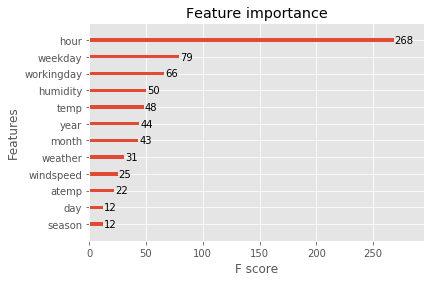

In [207]:
plt.style.use('ggplot') 
xg.plot_importance(clf_XGR)

# plt.style.use('ggplot') 
xgb.plot_importance(bst) 

xgb.to_graphviz(clf_XGR, num_trees=2)

    